In [38]:
import matplotlib.pyplot as plt
import os
import csv

In [39]:
def get_total_size(path, n_files):
    filenames = sorted(os.listdir(path))[:n_files]
    total_size = sum([os.path.getsize(path + filename) for filename in filenames])
    return total_size / (2**30)

def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

def col_standard_deviation(data):
    n_rows = len(data)
    n_cols = len(data[0])
    mean = col_average(data)
    return [(sum([(data[i][j] - mean[j])**2 for i in range(1, n_rows)]) / (n_rows - 1))**0.5 for j in range(n_cols)]

In [53]:
with open("runtime_tests_uproot/128_files/runtime_vs_processes_128_128_4_11.csv", "r") as f:
        runtime_vs_processes_uproot = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_rdf/128_files/runtime_vs_processes_128_4_11.csv", "r") as f:
        runtime_vs_processes_rdf = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_uproot/128_files/runtime_vs_size_mp_64_128_4_11.csv", "r") as f:
        runtime_vs_size_uproot_64 = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_rdf/128_files/runtime_vs_size_mp_64_128_4_11.csv", "r") as f:
        runtime_vs_size_rdf_64 = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_uproot/128_files/runtime_vs_size_mp_32_128_4_11.csv", "r") as f:
        runtime_vs_size_uproot_32 = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_rdf/128_files/runtime_vs_size_mp_32_128_4_11.csv", "r") as f:
        runtime_vs_size_rdf_32 = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_uproot/128_files/runtime_vs_size_mp_16_128_4_11.csv", "r") as f:
        runtime_vs_size_uproot_16 = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_rdf/128_files/runtime_vs_size_mp_16_128_4_11.csv", "r") as f:
        runtime_vs_size_rdf_16 = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_uproot/128_files/runtime_vs_size_128_4_11.csv", "r") as f:
        runtime_vs_size_uproot = [[float(a) for a in row] for row in csv.reader(f)]
with open("runtime_tests_rdf/128_files/runtime_vs_size_128_4_11.csv", "r") as f:
        runtime_vs_size_rdf = [[float(a) for a in row] for row in csv.reader(f)]

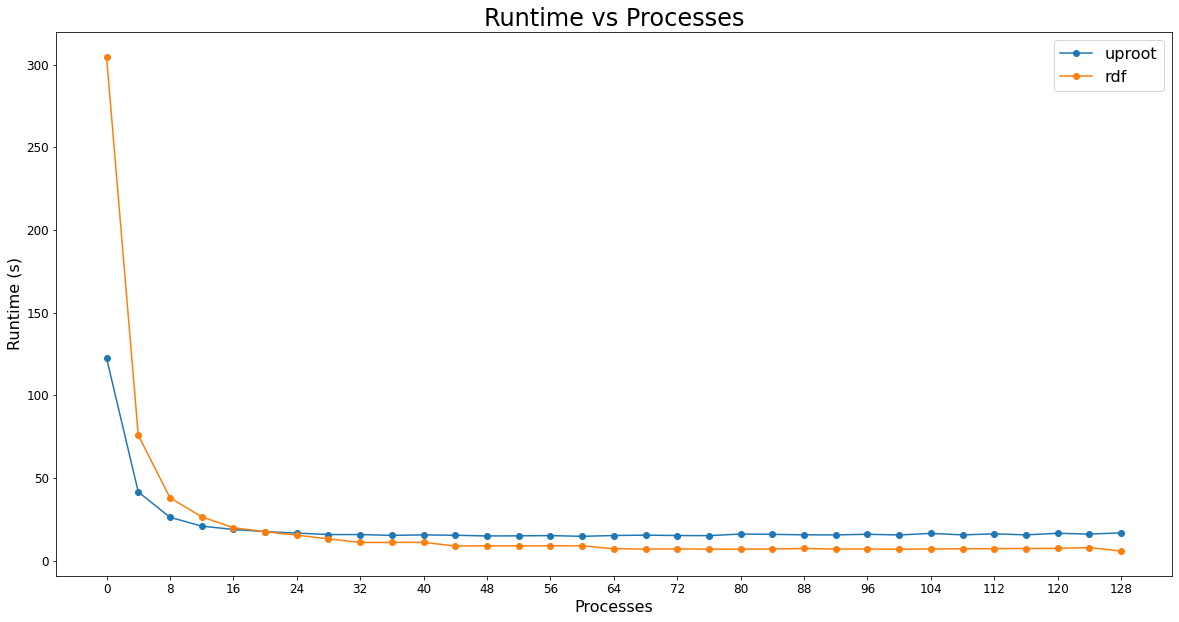

In [54]:
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Processes', fontsize=24)
plt.xlabel('Processes', fontsize=16)
plt.ylabel('Runtime (s)', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(runtime_vs_processes_uproot[0], col_average(runtime_vs_processes_uproot[1:]), marker="o", label="uproot")
plt.plot(runtime_vs_processes_rdf[0], col_average(runtime_vs_processes_rdf[1:]), marker="o", label="rdf")
plt.legend(prop={'size': 16})
plt.show()

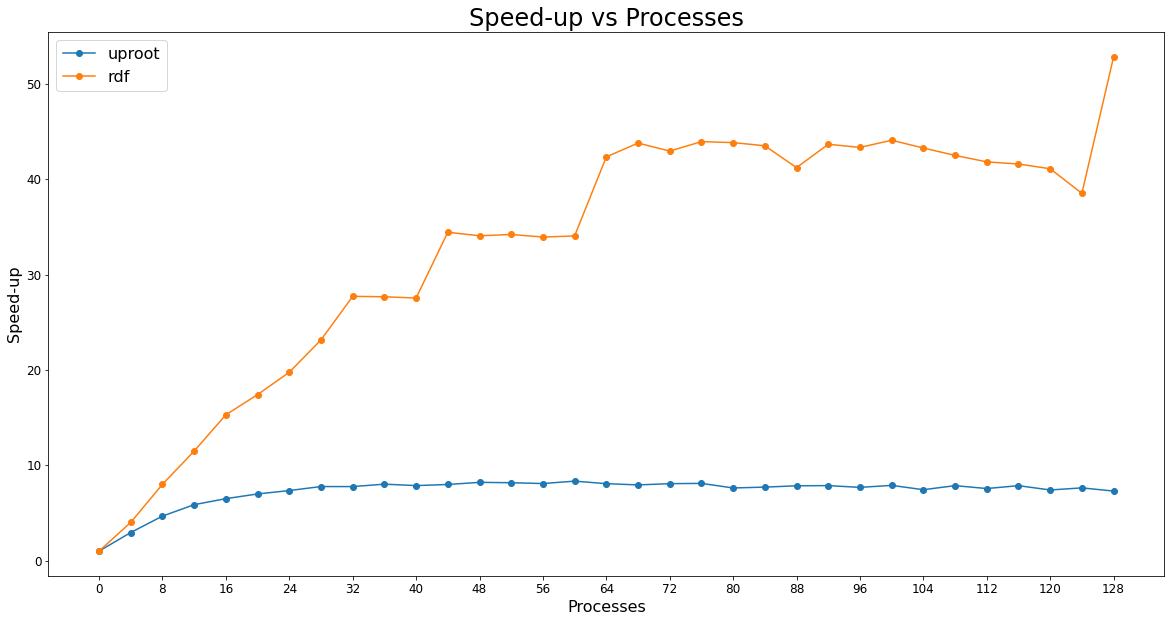

In [55]:
plt.figure(figsize = (20, 10))
plt.title('Speed-up vs Processes', fontsize=24)
plt.xlabel('Processes', fontsize=16)
plt.ylabel('Speed-up', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(runtime_vs_processes_uproot[0], [col_average(runtime_vs_processes_uproot[1:])[0] / n for n in col_average(runtime_vs_processes_uproot[1:])], marker="o", label="uproot")
plt.plot(runtime_vs_processes_rdf[0], [col_average(runtime_vs_processes_rdf[1:])[0] / n for n in col_average(runtime_vs_processes_rdf[1:])], marker="o", label="rdf")
plt.legend(prop={'size': 16})
plt.show()

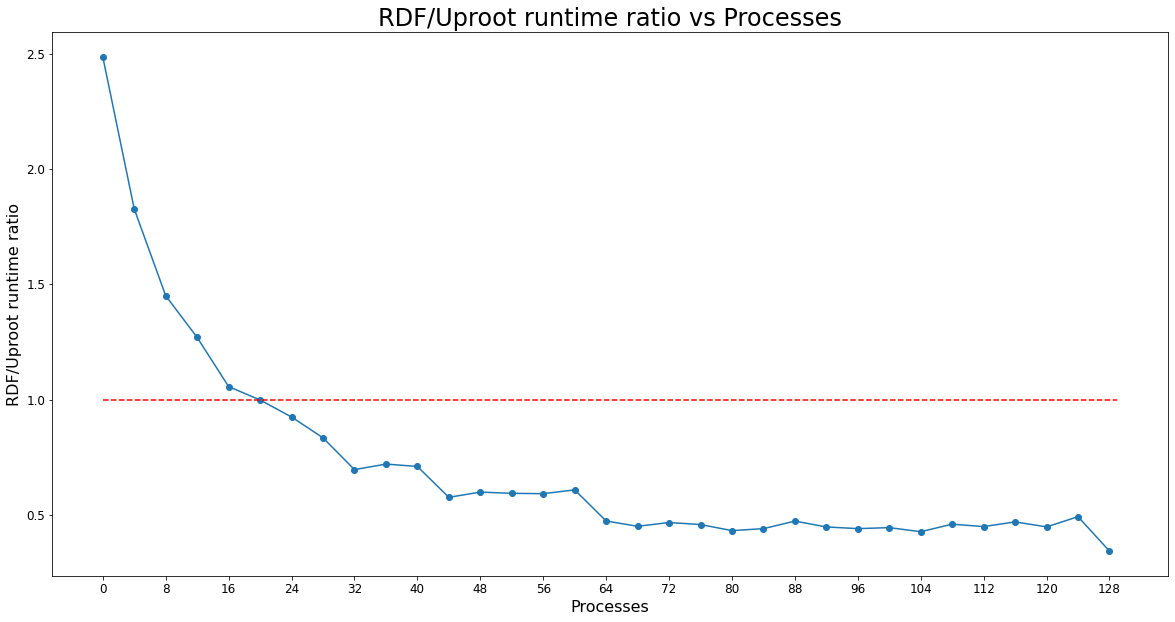

In [56]:
plt.figure(figsize = (20, 10))
plt.title('RDF/Uproot runtime ratio vs Processes', fontsize=24)
plt.xlabel('Processes', fontsize=16)
plt.ylabel('RDF/Uproot runtime ratio', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(runtime_vs_processes_uproot[0], [col_average(runtime_vs_processes_rdf[1:])[i] / col_average(runtime_vs_processes_uproot[1:])[i] for i in range(len(runtime_vs_processes_uproot[0]))], marker="o")
plt.hlines(y=1, xmin=0, xmax=129, color='red', linestyle ='dashed')
plt.show()

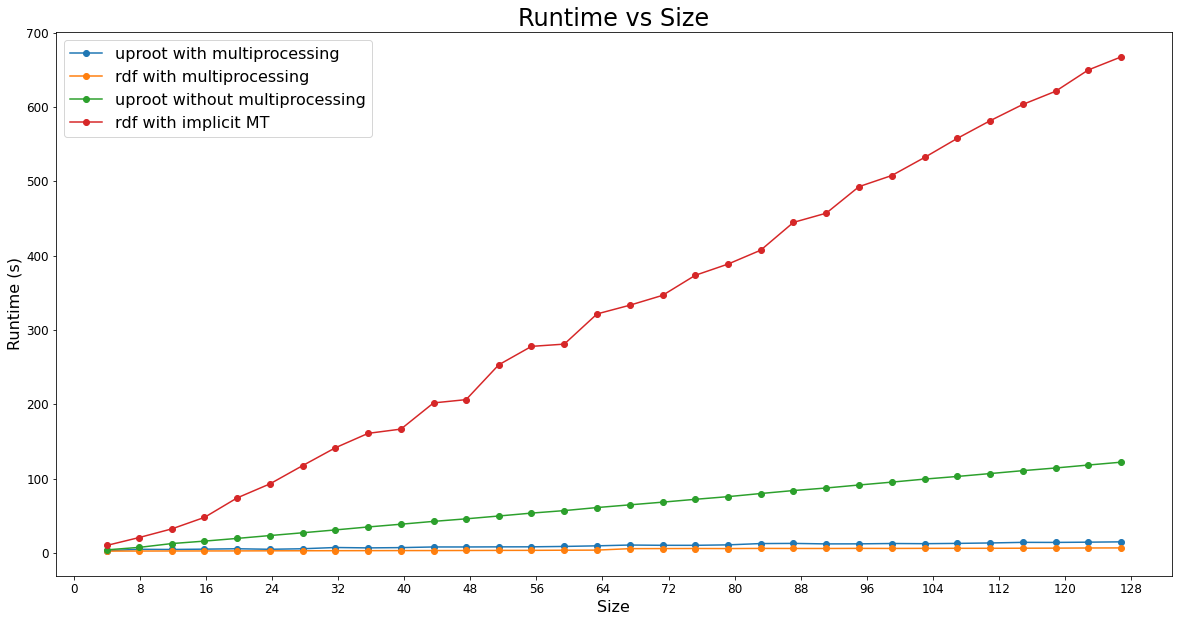

In [57]:
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Size', fontsize=24)
plt.xlabel('Size', fontsize=16)
plt.ylabel('Runtime (s)', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(runtime_vs_size_uproot_64[0], col_average(runtime_vs_size_uproot_64[1:]), marker="o", label="uproot with multiprocessing")
plt.plot(runtime_vs_size_rdf_64[0], col_average(runtime_vs_size_rdf_64[1:]), marker="o", label="rdf with multiprocessing")
plt.plot(runtime_vs_size_uproot[0], col_average(runtime_vs_size_uproot[1:]), marker="o", label="uproot without multiprocessing")
plt.plot(runtime_vs_size_rdf[0], col_average(runtime_vs_size_rdf[1:]), marker="o", label="rdf with implicit MT")
plt.legend(prop={'size': 16})
plt.show()

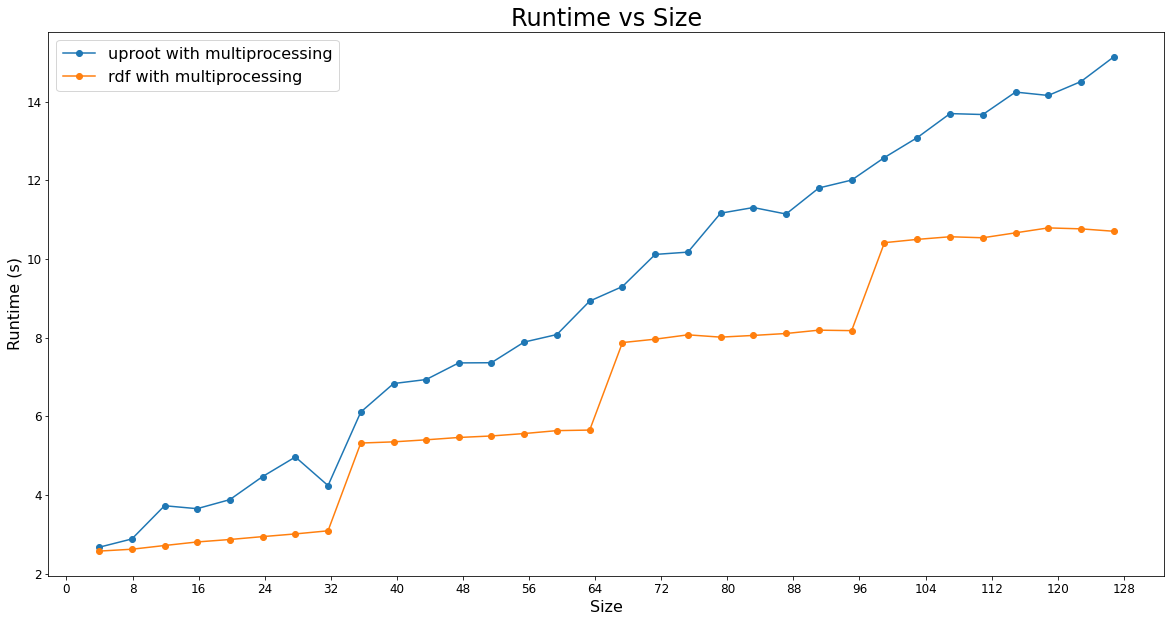

In [45]:
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Size', fontsize=24)
plt.xlabel('Size', fontsize=16)
plt.ylabel('Runtime (s)', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(runtime_vs_size_uproot_32[0], col_average(runtime_vs_size_uproot_32[1:]), marker="o", label="uproot with multiprocessing")
plt.plot(runtime_vs_size_rdf_32[0], col_average(runtime_vs_size_rdf_32[1:]), marker="o", label="rdf with multiprocessing")
# plt.plot(runtime_vs_size_uproot[0], col_average(runtime_vs_size_uproot[1:]), marker="o", label="uproot without multiprocessing")
# plt.plot(runtime_vs_size_uproot[0], col_average(runtime_vs_size_rdf[1:]), marker="o", label="rdf with implicit MT")
plt.legend(prop={'size': 16})
plt.show()

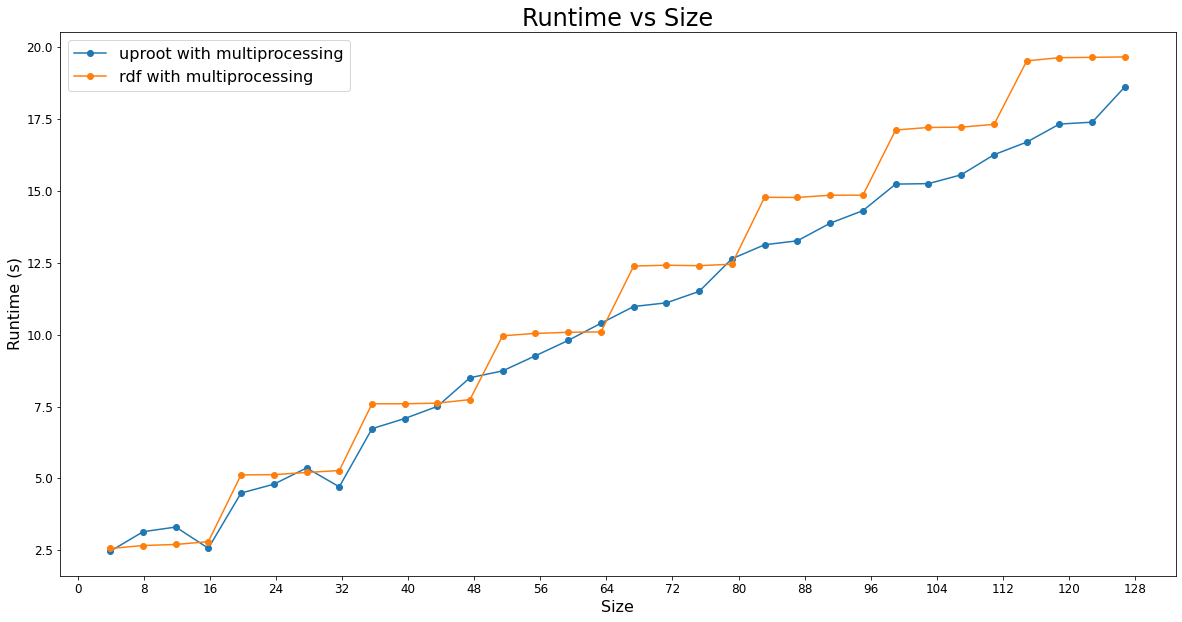

In [46]:
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Size', fontsize=24)
plt.xlabel('Size', fontsize=16)
plt.ylabel('Runtime (s)', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(runtime_vs_size_uproot_16[0], col_average(runtime_vs_size_uproot_16[1:]), marker="o", label="uproot with multiprocessing")
plt.plot(runtime_vs_size_rdf_16[0], col_average(runtime_vs_size_rdf_16[1:]), marker="o", label="rdf with multiprocessing")
# plt.plot(runtime_vs_size_uproot[0], col_average(runtime_vs_size_uproot[1:]), marker="o", label="uproot without multiprocessing")
# plt.plot(runtime_vs_size_uproot[0], col_average(runtime_vs_size_rdf[1:]), marker="o", label="rdf with implicit MT")
plt.legend(prop={'size': 16})
plt.show()